In [1]:
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np

# Function to process each txt file
def process_txt_files(folder_path):
    # Create an empty list to hold the arrays
    result_array = []
    sorted_files = sorted(os.listdir(folder_path))
    # Iterate through all files in the folder
    for filename in sorted_files:
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            try:
                with open(file_path, 'r') as file:
                    first_line = file.readline().strip()

                    # If the file has a first line, extract dimensions from it
                    if first_line:
                        values = list(map(float, first_line.split()))
                        # Check if the first line has exactly 5 elements
                        if len(values) == 5:
                            result_array.append(values[1:])  # Append everything except the first element
                        else:
                            result_array.append([0, 0, 0, 0])  # Default in case of unexpected format
                            print("Unexpected format detected")
                    else:
                        # If there is no first line, append 0 0 0 0
                        result_array.append([0, 0, 0, 0])
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    # Convert the list to a numpy array
    result_array = np.array(result_array)
    return result_array

In [3]:
boxes_estimated = process_txt_files("yolov5/runs/detect/exp2/labels")
np.save("yolo_boxes/boxes_estimated3", boxes_estimated) #number goes up for each time it is estimated

In [ ]:
true_boxes = process_txt_files("yolo_data/label3/test")
np.save("yolo_boxes/boxes_true3", true_boxes)

In [16]:
#use if you already have the true boxes saved
true_boxes = np.load("yolo_boxes/boxes_true.npy")
print(true_boxes.shape)


(59995, 4)


In [17]:
#use if you have the guesses saved
boxes_estimated = np.load("yolo_boxes/boxes_estimated.npy")
print(boxes_estimated.shape)


(59863, 4)


In [19]:
print(true_boxes.shape) # should be N x 4
print(boxes_estimated.shape)
#append boxes estimated with empties for each empty box, remove that from the IOU calc
import os


print(boxes_estimated.shape)
print(boxes_estimated[0])
print(true_boxes[0])
print(true_boxes.shape)

(59863, 4)
(59863, 4)
(59863, 4)
[0.321429 0.535714 0.5      0.428571]
[0.35714287 0.5714286  0.35714287 0.35714287]
(59863, 4)


In [20]:
#Ok, now we calculate IOU using the YOLO files 

def calculate_avg_iou(labels1, labels2):
    """
    Calculate the average Intersection over Union (IoU) for two sets of YOLO bounding boxes.
    
    Each label is in the format: [x_center, y_center, width, height]
    
    :param labels1: N x 4 numpy array of YOLO labels for the first set
    :param labels2: N x 4 numpy array of YOLO labels for the second set
    :return: Average IoU value
    """
    # Initialize list to store individual IoU values
    iou_values = []
    
    # Loop through each pair of boxes from both sets
    for i in range(len(labels1)):
        # Extract bounding box details for both labels
        x_center1, y_center1, w1, h1 = labels1[i]
        x_center2, y_center2, w2, h2 = labels2[i]
        
        # Convert YOLO format to corner coordinates (min and max)
        x1_min = x_center1 - w1 / 2
        y1_min = y_center1 - h1 / 2
        x1_max = x_center1 + w1 / 2
        y1_max = y_center1 + h1 / 2
        
        x2_min = x_center2 - w2 / 2
        y2_min = y_center2 - h2 / 2
        x2_max = x_center2 + w2 / 2
        y2_max = y_center2 + h2 / 2
        
        # Calculate the intersection area
        x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
        y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
        intersection_area = x_overlap * y_overlap
        
        # Calculate the union area
        area1 = w1 * h1
        area2 = w2 * h2
        union_area = area1 + area2 - intersection_area
        
        # Calculate IoU and store it
        iou = intersection_area / union_area if union_area > 0 else 1
        if union_area:
            iou_values.append(iou)
    # Calculate the average IoU
    avg_iou = np.mean(iou_values)
    return avg_iou

In [21]:
iou = calculate_avg_iou(boxes_estimated, true_boxes) 
print(iou)

0.6265541196450596


In [22]:
#now we do it for every 13th of the labeled boxes 

def calculate_avg_ious(labels1, labels2):
    """
    Calculate the average Intersection over Union (IoU) for two sets of YOLO bounding boxes.
    
    Each label is in the format: [x_center, y_center, width, height]
    
    :param labels1: N x 4 numpy array of YOLO labels for the first set
    :param labels2: N x 4 numpy array of YOLO labels for the second set
    :return: Average IoU value
    """
    one_thirteenth = int(labels1.shape[0]/13)
    # Initialize list to store individual IoU values
    split_iou_values = []
    iou_values = []
    avg_ious = []
    # Loop through each pair of boxes from both sets
    for i in range(len(labels1)):
        # Extract bounding box details for both labels
        x_center1, y_center1, w1, h1 = labels1[i]
        x_center2, y_center2, w2, h2 = labels2[i]
        
        # Convert YOLO format to corner coordinates (min and max)
        x1_min = x_center1 - w1 / 2
        y1_min = y_center1 - h1 / 2
        x1_max = x_center1 + w1 / 2
        y1_max = y_center1 + h1 / 2
        
        x2_min = x_center2 - w2 / 2
        y2_min = y_center2 - h2 / 2
        x2_max = x_center2 + w2 / 2
        y2_max = y_center2 + h2 / 2
        
        # Calculate the intersection area
        x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
        y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
        intersection_area = x_overlap * y_overlap
        
        # Calculate the union area
        area1 = w1 * h1
        area2 = w2 * h2
        union_area = area1 + area2 - intersection_area
        
        # Calculate IoU and store it
        iou = intersection_area / union_area if union_area > 0 else 1
        
        iou_values.append(iou)
        
        if len(iou_values)%one_thirteenth == 0: 
            split_iou_values.append(iou_values) 
            iou_values = []
    # Calculate the average IoU
    for iou_val in split_iou_values:
        avg_iou = np.mean(iou_val)
        avg_ious.append(avg_iou)
    return avg_ious


In [23]:
ious = calculate_avg_ious(boxes_estimated, true_boxes)[:13]
print(ious)
print(len(ious))

[0.37264476311548345, 0.51567890024004, 0.6037901507407881, 0.6784717582913802, 0.6876617504610417, 0.6937282392505295, 0.6960274571269666, 0.6742801317664432, 0.6727777199616497, 0.6485700095306273, 0.6457268734088819, 0.6307912567510785, 0.6251351666633003]
13


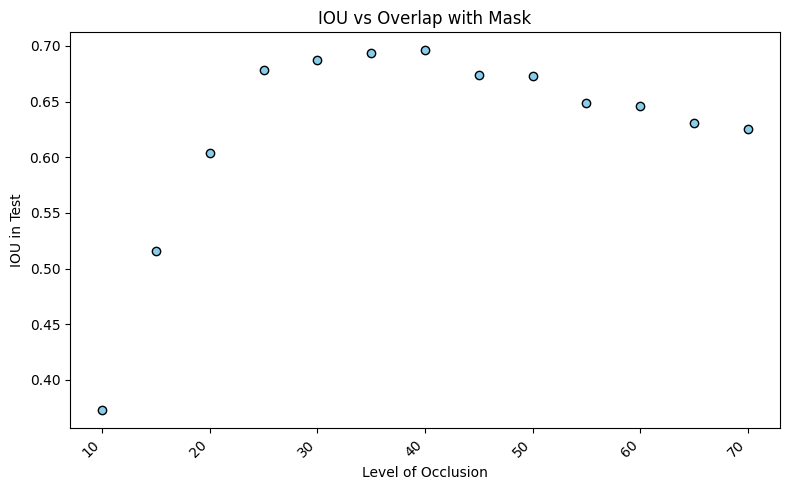

In [33]:
keys = [5*i + 10 for i in range(0, 13)]
values = ious
plt.figure(figsize=(8, 5))
plt.scatter(keys, values, color='skyblue', edgecolor='black')
plt.title("IOU vs Overlap with Mask")
plt.xlabel("Level of Occlusion")
plt.ylabel("IOU in Test")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("mnist_obfuscated/IOU_level.png", dpi=300)
plt.show()

In [126]:
np.save("yolo_boxes/boxes_estimated2", boxes_estimated)
np.save("yolo_boxes/boxes_true2", true_boxes)

In [25]:
#Need to also calculate the avg amount of the boxes that cover the corrupted region 
def calculate_avg_coverage(labels1, labels2):
    """
    Calculate the average Intersection over Union (IoU) for two sets of YOLO bounding boxes.
    
    Each label is in the format: [x_center, y_center, width, height]
    
    :param labels1: N x 4 numpy array of YOLO labels for the first set
    :param labels2: N x 4 numpy array of YOLO labels for the second set
    :return: Average IoU value
    """
    # Initialize list to store individual IoU values
    coverage_values = []
    
    # Loop through each pair of boxes from both sets
    for i in range(len(labels1)):
        # Extract bounding box details for both labels
        x_center1, y_center1, w1, h1 = labels1[i]
        x_center2, y_center2, w2, h2 = labels2[i]
        
        # Convert YOLO format to corner coordinates (min and max)
        x1_min = x_center1 - w1 / 2
        y1_min = y_center1 - h1 / 2
        x1_max = x_center1 + w1 / 2
        y1_max = y_center1 + h1 / 2
        
        x2_min = x_center2 - w2 / 2
        y2_min = y_center2 - h2 / 2
        x2_max = x_center2 + w2 / 2
        y2_max = y_center2 + h2 / 2
        
        # Calculate the intersection area
        x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
        y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
        intersection_area = x_overlap * y_overlap
        
        # Calculate the size of the area you want to contain 
        area1 = w1 * h1
        
        # Calculate IoU and store it
        coverage = intersection_area / area1 if area1 > 0 else 1
        if area1:
            coverage_values.append(coverage)
    # Calculate the average IoU
    avg_coverage = np.mean(coverage_values)
    return avg_coverage

In [27]:
coverage = calculate_avg_coverage(true_boxes, boxes_estimated) 
print(coverage)

0.7882910734767073


In [28]:
#now do it per level of occlusion 
def calculate_avg_coverages(labels1, labels2):
    """
    Calculate the average Intersection over Union (IoU) for two sets of YOLO bounding boxes.
    
    Each label is in the format: [x_center, y_center, width, height]
    
    :param labels1: N x 4 numpy array of YOLO labels for the first set
    :param labels2: N x 4 numpy array of YOLO labels for the second set
    :return: Average IoU value
    """
    one_thirteenth = int(labels1.shape[0]/13)
    # Initialize list to store individual IoU values
    split_coverage_values = []
    coverage_values = []
    avg_coverages = []
    # Loop through each pair of boxes from both sets
    for i in range(len(labels1)):
        # Extract bounding box details for both labels
        x_center1, y_center1, w1, h1 = labels1[i]
        x_center2, y_center2, w2, h2 = labels2[i]
        
        # Convert YOLO format to corner coordinates (min and max)
        x1_min = x_center1 - w1 / 2
        y1_min = y_center1 - h1 / 2
        x1_max = x_center1 + w1 / 2
        y1_max = y_center1 + h1 / 2
        
        x2_min = x_center2 - w2 / 2
        y2_min = y_center2 - h2 / 2
        x2_max = x_center2 + w2 / 2
        y2_max = y_center2 + h2 / 2
        
        # Calculate the intersection area
        x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
        y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
        intersection_area = x_overlap * y_overlap
        
        # Calculate the true area
        true_area = w1 * h1
        
        # Calculate IoU and store it
        coverage = intersection_area / true_area if true_area > 0 else 1
        
        coverage_values.append(coverage)
        
        if len(coverage_values)%one_thirteenth == 0: 
            split_coverage_values.append(coverage_values) 
            coverage_values = []
    # Calculate the average IoU
    for c in split_coverage_values:
        avg_coverage = np.mean(c)
        avg_coverages.append(avg_coverage)
    return avg_coverages

[0.7405223207984682, 0.8209870610243062, 0.8508347746809027, 0.876479805333413, 0.8624101378308329, 0.8512815588396258, 0.832655678320865, 0.7916080964398903, 0.7824545953543607, 0.7370129497908215, 0.7289826937470957, 0.6915012461439644, 0.6813323296151533]
13


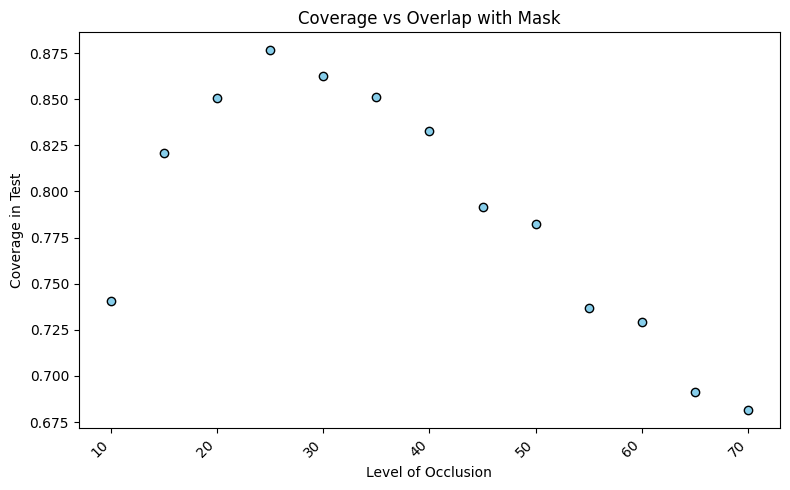

In [34]:
coverages = calculate_avg_coverages(true_boxes, boxes_estimated)[:13]
print(coverages)
print(len(coverages))
keys = [5*i + 10 for i in range(0, 13)]
values = coverages
plt.figure(figsize=(8, 5))
plt.scatter(keys, values, color='skyblue', edgecolor='black')
plt.title("Coverage vs Overlap with Mask")
plt.xlabel("Level of Occlusion")
plt.ylabel("Coverage in Test")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("mnist_obfuscated/Coverage_level.png", dpi=300)
plt.show()

In [18]:
##USE THIS WHEN THE NUMBER OF BOXES DOESN'T LINE UP 
# # Path to your folder
folder_path = 'yolov5/runs/detect/exp9/labels'

# List all the .txt files
files = os.listdir(folder_path)

# Extract numbers from filenames
existing_numbers = set()
for filename in files:
    if filename.endswith('.txt'):
        try:
            num = int(filename[len('image_'):-4])  # skip "image_" and ".txt"
            existing_numbers.add(num)
        except ValueError:
            pass  # ignore files that don't match the pattern

# Now find missing numbers
all_numbers = set(range(59995))  # 0 to 59994 inclusive
missing_numbers = sorted(all_numbers - existing_numbers)
#remove the missing numbers from the true_boxes 
true_boxes = np.delete(true_boxes, missing_numbers, axis = 0)